In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from datetime import datetime, timedelta
import json
from math import ceil
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

sys.path.append('..')
from models.qp.qpercent import QPercent
from util.batcher import Batcher
from util.stock_loader import Loader

In [3]:
!ls ../models/qp

__pycache__ data        qpercent.py


In [4]:
N_YEARS = 3
N_CUTS = 4
N_DAYS = int(round(365.25 * N_YEARS))
TODAY = (datetime.now() + timedelta(1)).date()
START = str(TODAY - timedelta(N_DAYS))  # '1996-01-01' #
START, TODAY

('2019-04-10', datetime.date(2022, 4, 10))

[0.46566129 0.2213282  0.10519701 0.05       0.02376493 0.01129544
 0.00536871]


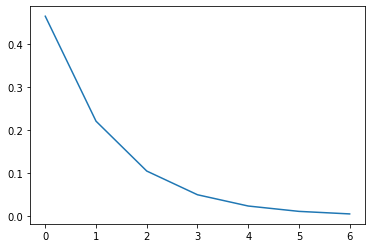

In [5]:
SDS = 0.05 * (0.8 ** np.linspace(-10, 10, 7))
print(SDS)
plt.plot(SDS);

In [6]:
SD = SDS[(TODAY.weekday() + 1) % 7] # 0 (largest SD) on Sat
SD

0.46566128730773904

In [7]:
DATA = '../models/qp/data'
SYMBOLS = [
    'AAPL', 'ABMD', 'ABNB', 'AMD', 'AMZN', 'ANET', 'APPH', 'AXON',
    'BROS', 'BYND', 'CHWY', 'COIN', 'COUR', 'CRWD', 'DDOG', 'DKNG',
    'DOCU', 'DUOL', 'EDIT', 'ETSY', 'FLGT', 'FUV', 'FVRR', 'GH', 'GMED',
    'GOOG', 'INTG', 'ISRG', 'JD', 'LSPD', 'LULU','MDB', 'MELI', 'MNST',
    'MSFT', 'MTCH', 'NVCR', 'NVDA', 'NYT', 'OKTA', 'OPEN', 'PANW',
    'PINS', 'PTON', 'QDEL', 'RBLX', 'RDFN', 'RGEN', 'ROKU', 'SE',
    'SHOP', 'SPLK', 'SQ', 'TASK', 'TDOC', 'TEAM', 'TREX', 'TTD', 'TTWO',
    'TWLO', 'TWTR', 'UPST', 'VEEV', 'WK', 'XPEV', 'ZEN', 'ZNGA']
INDICES = [
    '^GSPC', # S&P 500
    '^IXIC', # Nasdaq
    '^NYA',  # NY Stock Exchange (total)
    '^W5000'] # Wilshire 5k
len(SYMBOLS)

67

In [8]:
#batcher = Batcher(SYMBOLS, INDICES)
#batch = batcher.get_batch_from_weekday(TODAY.weekday())
#batch

In [9]:
cols = [
    (first, second)
    for first in ['Value', 'Close', 'High', 'Low', 'Open'] 
    for second in ['mine1', 'mine2']]
cols

[('Value', 'mine1'),
 ('Value', 'mine2'),
 ('Close', 'mine1'),
 ('Close', 'mine2'),
 ('High', 'mine1'),
 ('High', 'mine2'),
 ('Low', 'mine1'),
 ('Low', 'mine2'),
 ('Open', 'mine1'),
 ('Open', 'mine2')]

In [10]:
mine = pd.read_csv('../data/mine.csv')
#mine.mine1.iloc[-300:] = 8.1
mine.index = pd.to_datetime(mine['Date'])
mine.drop(columns='Date', inplace=True)
mine['cmine1'] = mine.mine1
mine['cmine2'] = mine.mine2
mine['hmine1'] = mine.mine1
mine['hmine2'] = mine.mine2
mine['lmine1'] = mine.mine1
mine['lmine2'] = mine.mine2
mine['omine1'] = mine.mine1
mine['omine2'] = mine.mine2
mine.columns = pd.MultiIndex.from_tuples(cols)
mine.tail()

Value                Close                 High            \
                mine1     mine2      mine1     mine2      mine1     mine2   
Date                                                                        
2022-04-04  20.751611  8.175625  20.751611  8.175625  20.751611  8.175625   
2022-04-05  20.011166  7.902315  20.011166  7.902315  20.011166  7.902315   
2022-04-06  19.281924  7.588986  19.281924  7.588986  19.281924  7.588986   
2022-04-07  19.160761  7.575626  19.160761  7.575626  19.160761  7.575626   
2022-04-08  18.732501  7.354080  18.732501  7.354080  18.732501  7.354080   

                  Low                 Open            
                mine1     mine2      mine1     mine2  
Date                                                  
2022-04-04  20.751611  8.175625  20.751611  8.175625  
2022-04-05  20.011166  7.902315  20.011166  7.902315  
2022-04-06  19.281924  7.588986  19.281924  7.588986  
2022-04-07  19.160761  7.575626  19.160761  7.575626  
2022-04-08  18.732501  7.354080  18.732501  7.354080

In [11]:
#batch = SYMBOLS + INDICES # run all
batch = INDICES
stock_loader = Loader(batch, START, str(TODAY), verbose=True)
data = stock_loader.download(append=mine)

[*********************100%***********************]  4 of 4 completed
Generating derived columns...
   ...^GSPC
   ...^IXIC
   ...^NYA
   ...^W5000
   ...mine1
   ...mine2


In [12]:
data.head()

Value                   Close                    High        ...  \
  ^GSPC ^IXIC ^NYA ^W5000 ^GSPC ^IXIC ^NYA ^W5000 ^GSPC ^IXIC  ...   
0   NaN   NaN  NaN    NaN   NaN   NaN  NaN    NaN   NaN   NaN  ...   
1   NaN   NaN  NaN    NaN   NaN   NaN  NaN    NaN   NaN   NaN  ...   
2   NaN   NaN  NaN    NaN   NaN   NaN  NaN    NaN   NaN   NaN  ...   
3   NaN   NaN  NaN    NaN   NaN   NaN  NaN    NaN   NaN   NaN  ...   
4   NaN   NaN  NaN    NaN   NaN   NaN  NaN    NaN   NaN   NaN  ...   

  DayToDayChange OvernightChange  LogValue IntradayChange DayToDayChange  \
          ^W5000          ^W5000     mine1          mine1          mine1   
0            NaN             NaN -0.020062            1.0            NaN   
1            NaN             NaN -0.007183            1.0       1.012962   
2            NaN             NaN  0.006624            1.0       1.013903   
3            NaN             NaN -0.005045            1.0       0.988398   
4            NaN             NaN -0.017959            1.0       0.987169   

  OvernightChange  LogValue IntradayChange DayToDayChange OvernightChange  
            mine1     mine2          mine2          mine2           mine2  
0             NaN -0.020062            1.0            NaN             NaN  
1        1.012962 -0.007255            1.0       1.012889        1.012889  
2        1.013903  0.006488            1.0       1.013838        1.013838  
3        0.988398 -0.005286            1.0       0.988295        0.988295  
4        0.987169 -0.018029            1.0       0.987338        0.987338  

[5 rows x 55 columns]

In [13]:
data['Date'].tail()

2513   2022-04-04
2514   2022-04-05
2515   2022-04-06
2516   2022-04-07
2517   2022-04-08
Name: Date, dtype: datetime64[ns]

In [14]:
data.index = pd.to_datetime(data['Date'])
data.head()

Value                   Close                    High        ...  \
     ^GSPC ^IXIC ^NYA ^W5000 ^GSPC ^IXIC ^NYA ^W5000 ^GSPC ^IXIC  ...   
Date                                                              ...   
NaT    NaN   NaN  NaN    NaN   NaN   NaN  NaN    NaN   NaN   NaN  ...   
NaT    NaN   NaN  NaN    NaN   NaN   NaN  NaN    NaN   NaN   NaN  ...   
NaT    NaN   NaN  NaN    NaN   NaN   NaN  NaN    NaN   NaN   NaN  ...   
NaT    NaN   NaN  NaN    NaN   NaN   NaN  NaN    NaN   NaN   NaN  ...   
NaT    NaN   NaN  NaN    NaN   NaN   NaN  NaN    NaN   NaN   NaN  ...   

     DayToDayChange OvernightChange  LogValue IntradayChange DayToDayChange  \
             ^W5000          ^W5000     mine1          mine1          mine1   
Date                                                                          
NaT             NaN             NaN -0.020062            1.0            NaN   
NaT             NaN             NaN -0.007183            1.0       1.012962   
NaT             NaN             NaN  0.006624            1.0       1.013903   
NaT             NaN             NaN -0.005045            1.0       0.988398   
NaT             NaN             NaN -0.017959            1.0       0.987169   

     OvernightChange  LogValue IntradayChange DayToDayChange OvernightChange  
               mine1     mine2          mine2          mine2           mine2  
Date                                                                          
NaT              NaN -0.020062            1.0            NaN             NaN  
NaT         1.012962 -0.007255            1.0       1.012889        1.012889  
NaT         1.013903  0.006488            1.0       1.013838        1.013838  
NaT         0.988398 -0.005286            1.0       0.988295        0.988295  
NaT         0.987169 -0.018029            1.0       0.987338        0.987338  

[5 rows x 55 columns]

In [15]:
def get_stock_data(stock, data):
    sub = data.loc[
        :,  
        [x for x in list(data) if x[1] == stock or x[0] == 'Date']]
    first_value = sub.Value[stock][sub.Value[stock].notna()].index[0]
    sub = sub.loc[first_value:, :]
    sub.index = range(sub.shape[0])
    sub.columns = sub.columns.to_series().apply(lambda x: x[0])
    return sub

In [16]:
def str_to_tuple(s):
    s = s[1:-1]
    return tuple([float(x) for x in s.split(', ')])

str_to_tuple('(0.123, 0.456)')

(0.123, 0.456)

In [17]:
def read_best_params(stock):
    try:
        with open(f'{DATA}/{stock}_best_{N_YEARS}_years.json', 'r') as f:
            params = json.load(f)
        for k in params:
            params[k]['q_params'] = {
                str_to_tuple(k): v 
                for k, v in params[k]['q_params'].items()}
        best_returns = {k: params[k]['best_return'] for k in params}
        print('Loaded current best.')
        return params, best_returns
    except FileNotFoundError:
        print('No saved data. Initialized as None')
        return None, None
    except:
        print(
            f'Unexpected error getting {stock} data. Initialized as '
            f'None.')

In [18]:
def get_best_param_set(qp):
    best_param_set = qp.best_param_set
    for method in best_param_set:
        best_param_set[method]['best_return'] = qp.best_returns[method]
        # stringify tuple keys:
        best_param_set[method]['q_params'] = {
            str(k): v 
            for k, v in best_param_set[method]['q_params'].items()}
    return best_param_set

In [19]:
def save_best_param_set(best_param_set, stock):
    print(f'Saving {stock} params...')
    with open(f'{DATA}/{stock}_best_{N_YEARS}_years.json', 'w') as f:
        json.dump(best_param_set, f)

In [20]:
SDS

array([0.46566129, 0.2213282 , 0.10519701, 0.05      , 0.02376493,
       0.01129544, 0.00536871])

SD: 0.46566128730773904



----------------------------------------------------------------------
                                 ^GSPC
----------------------------------------------------------------------
Loaded current best.


Beginning ma method...
--------------------------------------------------
Do nothing returns: 1.4506211065439887
Refitting current best...
Current best ma returns: 1.6346966204517903
Fraction Invested: 0.9996090475100549
Beginning random search...
Round: 10
Beginning adjusted search...
New best: 1.6348758982462495
Invested: 0.9999368867342607
New best: 1.6350852712367967
Invested: 0.9999368867342607
New best: 1.635090370089824
Invested: 0.9999462091674697
New best: 1.6410718477014299
Invested: 0.9999462091674697
New best: 1.6415377464470302
Invested: 0.9999462091674697
Round: 90


Beginning ew_ma method...
--------------------------------------------------
Do nothing returns: 1.4506211065439887
Refitting current best...
Current best ew_ma returns: 1.520965892

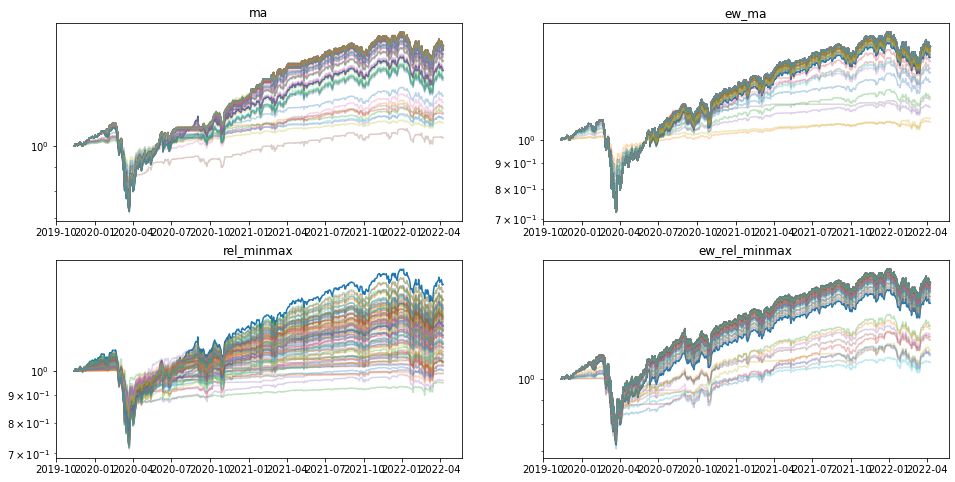

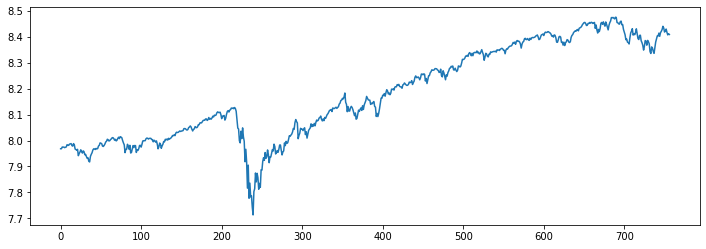

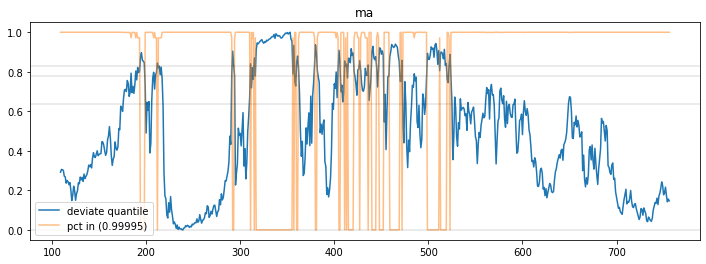

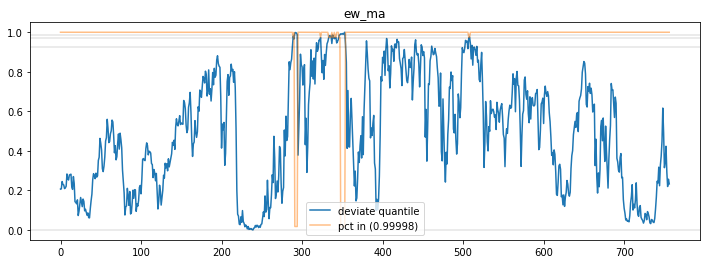

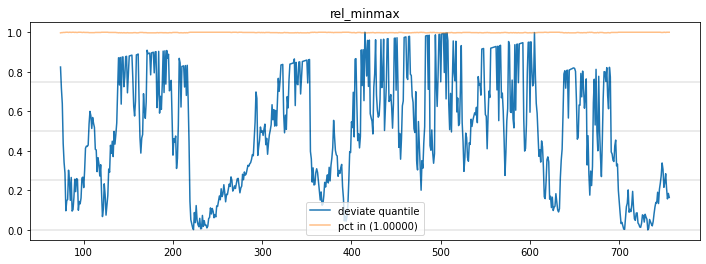

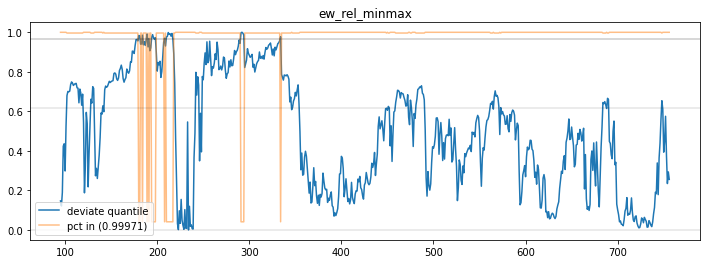

Saving ^GSPC params...



----------------------------------------------------------------------
                                 ^IXIC
----------------------------------------------------------------------
Loaded current best.


Beginning ma method...
--------------------------------------------------
Do nothing returns: 1.6164629786763716
Refitting current best...
Current best ma returns: 1.8499355068963317
Fraction Invested: 0.9989219852805626
Beginning random search...
Round: 10
Beginning adjusted search...
New best: 1.8510411276832632
Invested: 0.9999889848999205
New best: 1.8511634736416698
Invested: 0.9999889848999205
New best: 1.8511634791434284
Invested: 0.9999889848999205
Round: 90


Beginning ew_ma method...
--------------------------------------------------
Do nothing returns: 1.6164629786763716
Refitting current best...
Current best ew_ma returns: 1.7655671503486476
Fraction Invested: 0.9960000707867868
Beginning random search...
Round: 10
Beginning adjusted search...
New 

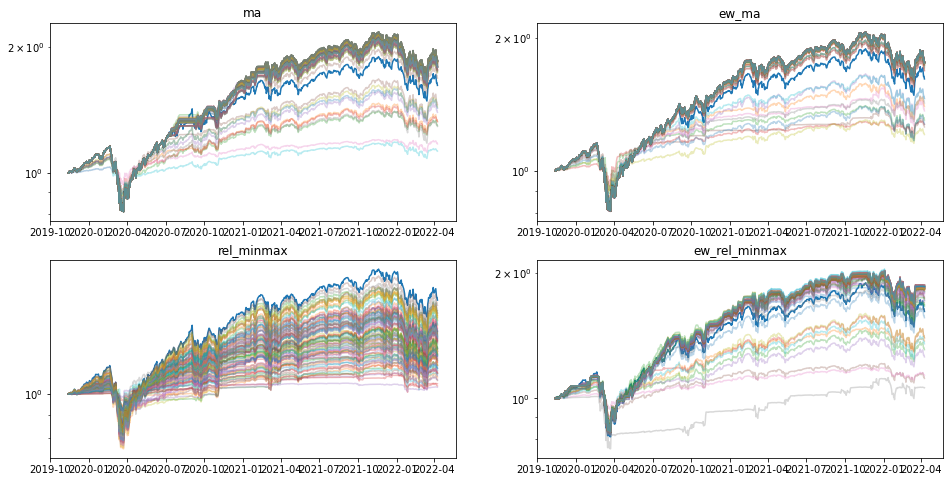

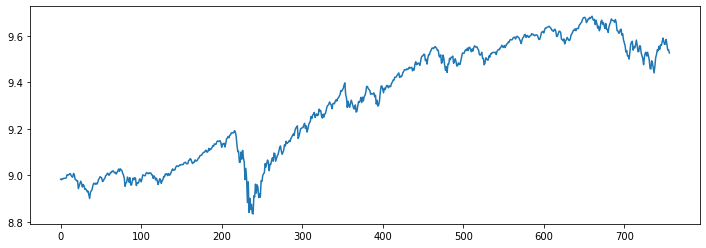

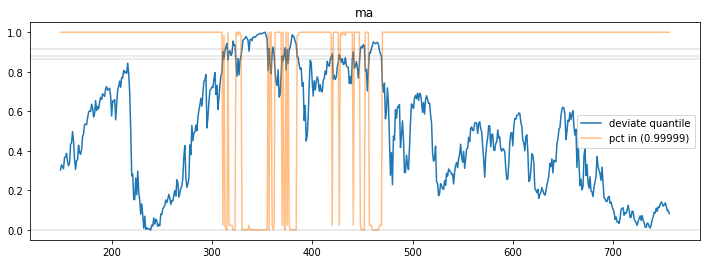

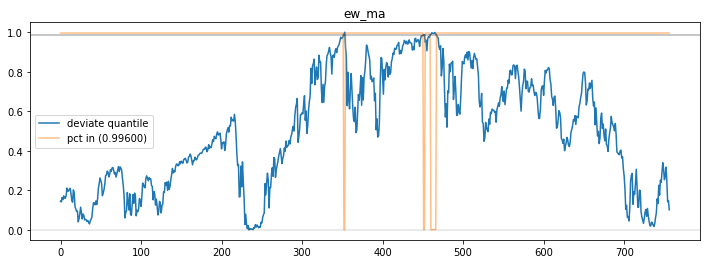

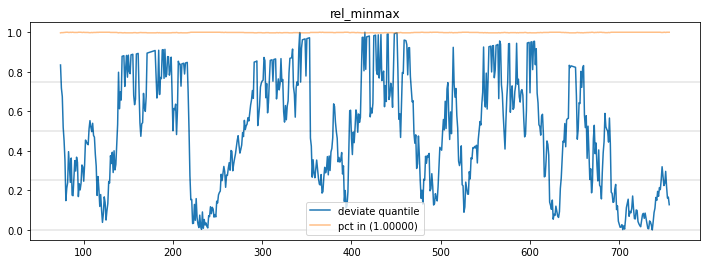

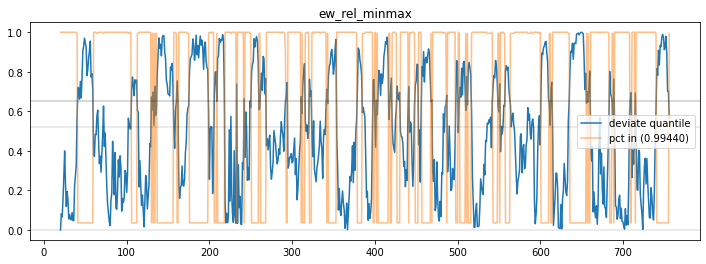

Saving ^IXIC params...



----------------------------------------------------------------------
                                 ^NYA
----------------------------------------------------------------------
Loaded current best.


Beginning ma method...
--------------------------------------------------
Do nothing returns: 1.2469097584459574
Refitting current best...
Fraction Invested: 1
Beginning random search...
Round: 10
No best to adjust. Continuing random
Beginning random search...
Round: 90


Beginning ew_ma method...
--------------------------------------------------
Do nothing returns: 1.2469097584459574
Refitting current best...
Fraction Invested: 1
Beginning random search...
Round: 10
No best to adjust. Continuing random
Beginning random search...
New best: 1.2602676710888154
Invested: 0.966035924020326
Round: 90


Beginning rel_minmax method...
--------------------------------------------------
Do nothing returns: 1.2469097584459574
Refitting current best...
Fraction Invested:

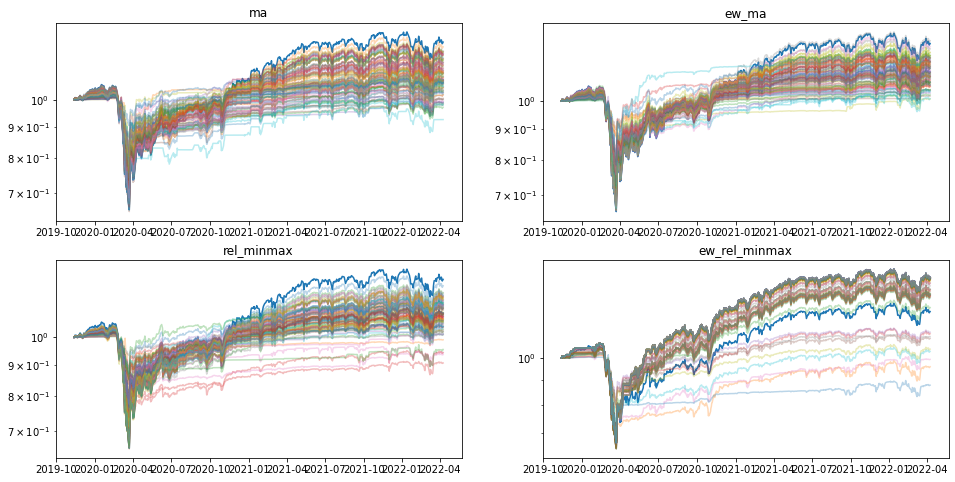

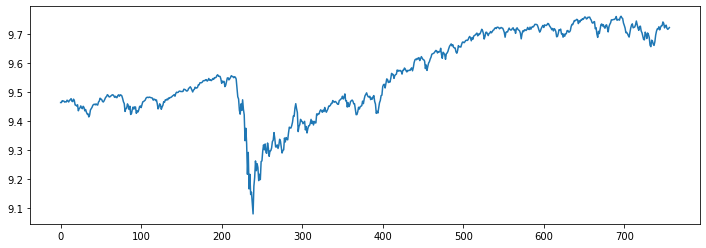

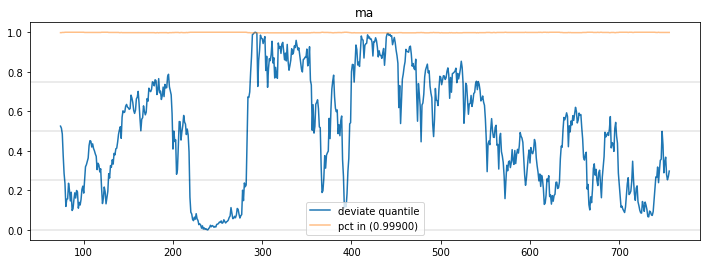

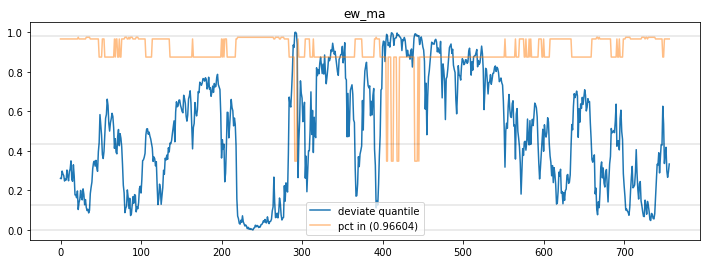

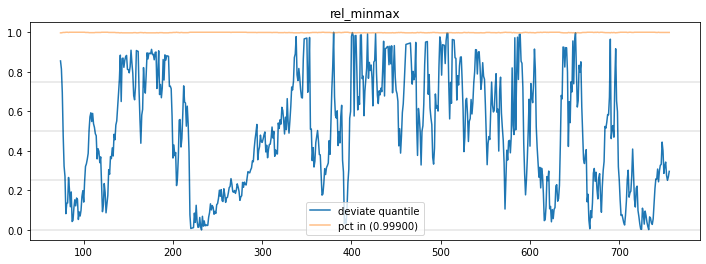

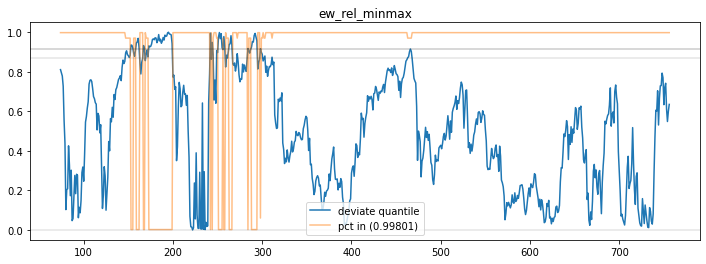

Saving ^NYA params...



----------------------------------------------------------------------
                                 ^W5000
----------------------------------------------------------------------
Loaded current best.


Beginning ma method...
--------------------------------------------------
Do nothing returns: 1.4263907010263852
Refitting current best...
Fraction Invested: 1
Beginning random search...
Round: 10
No best to adjust. Continuing random
Beginning random search...
Round: 90


Beginning ew_ma method...
--------------------------------------------------
Do nothing returns: 1.4263907010263852
Refitting current best...
Current best ew_ma returns: 1.5268963808906384
Fraction Invested: 0.9960461806374352
Beginning random search...
Round: 10
Beginning adjusted search...
New best: 1.5274731681544669
Invested: 0.9960461806374352
New best: 1.5329986095204113
Invested: 0.9960461806374352
New best: 1.534780756097039
Invested: 0.9998549436351082
New best: 1.5351433530044991
In

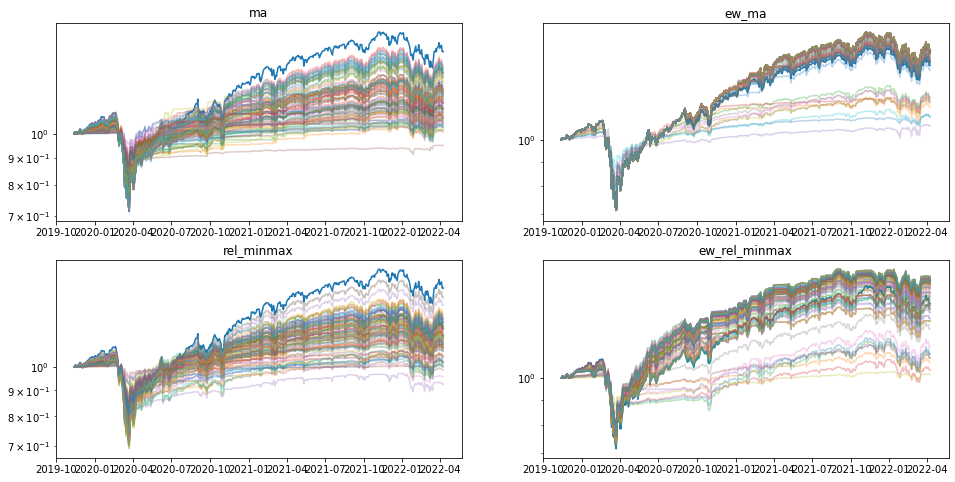

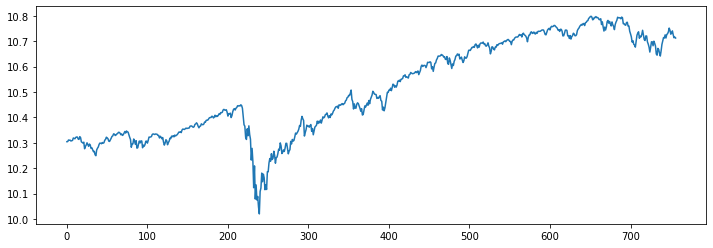

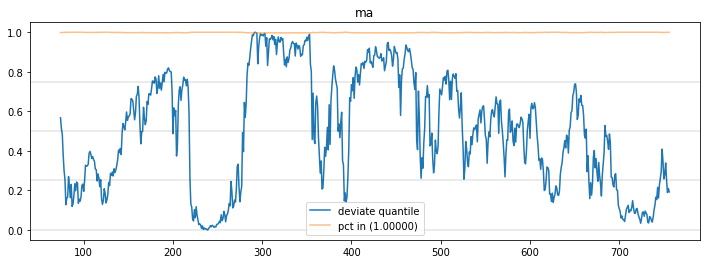

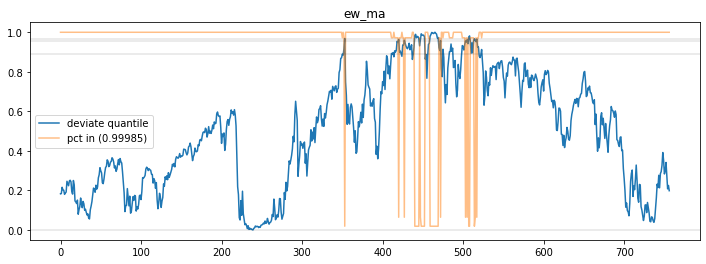

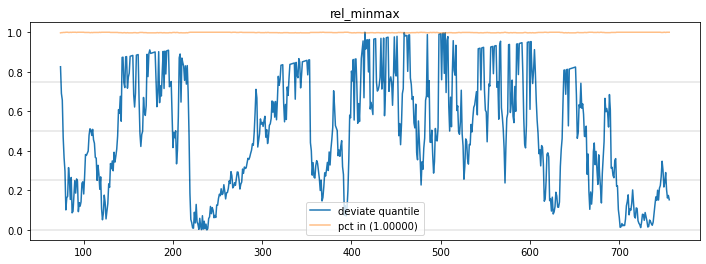

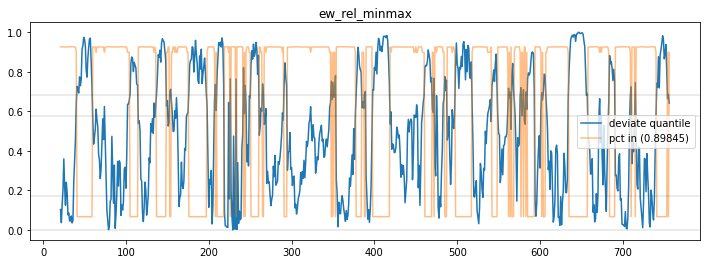

Saving ^W5000 params...



----------------------------------------------------------------------
                                 mine1
----------------------------------------------------------------------
Loaded current best.


Beginning ma method...
--------------------------------------------------
Do nothing returns: 2.392128247686147
Refitting current best...
Current best ma returns: 2.5972313885100857
Fraction Invested: 0.9992184216650054
Beginning random search...
Round: 10
Beginning adjusted search...
New best: 2.5975403592784896
Invested: 0.9998488672310303
New best: 2.597541804642447
Invested: 0.9998488672310303
New best: 2.5976148282034814
Invested: 0.9999886276271704
Round: 90


Beginning ew_ma method...
--------------------------------------------------
Do nothing returns: 2.392128247686147
Refitting current best...
Fraction Invested: 1
Beginning random search...
Round: 10
No best to adjust. Continuing random
Beginning random search...
Round: 90


Beginning rel_minmax me

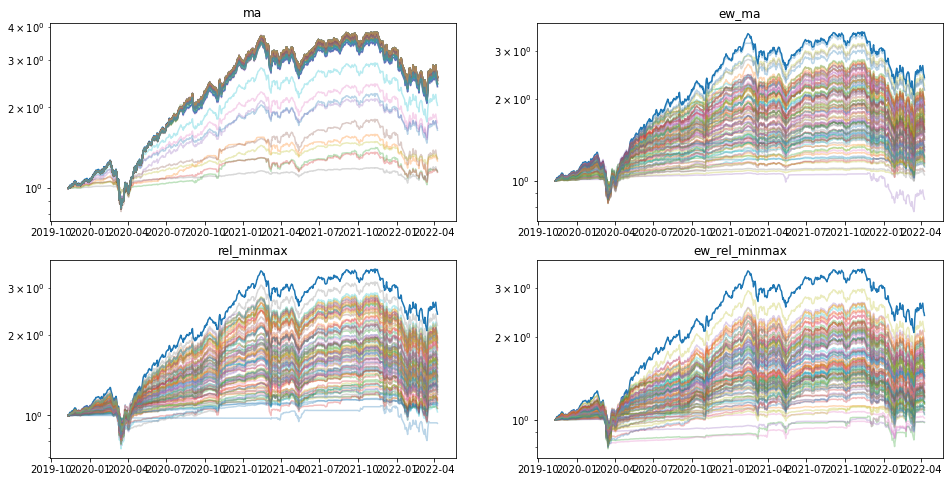

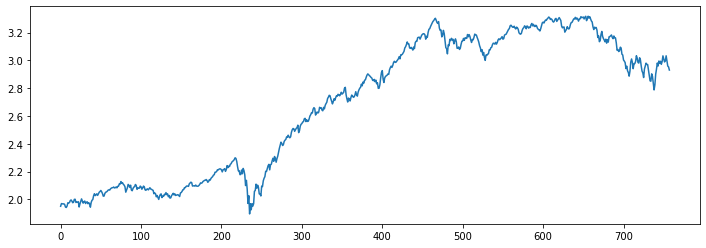

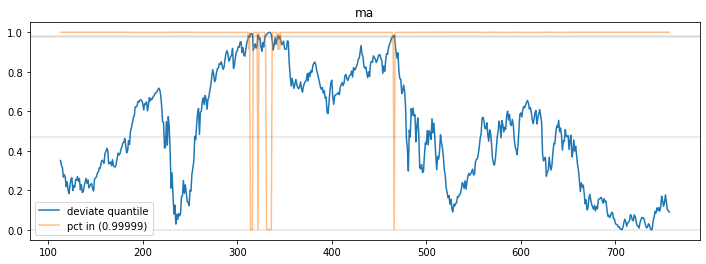

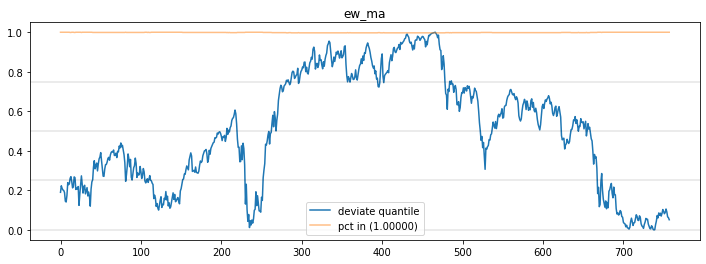

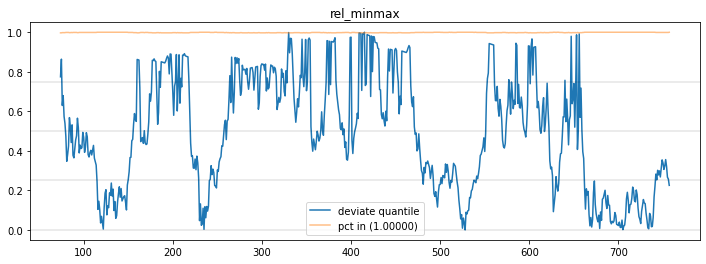

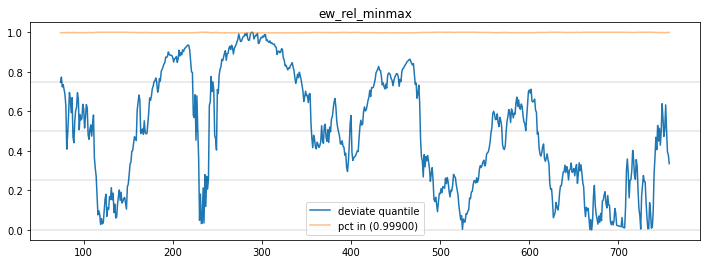

Saving mine1 params...



----------------------------------------------------------------------
                                 mine2
----------------------------------------------------------------------
Loaded current best.


Beginning ma method...
--------------------------------------------------
Do nothing returns: 1.7073697364393514
Refitting current best...
Fraction Invested: 1
Beginning random search...
Round: 10
No best to adjust. Continuing random
Beginning random search...
New best: 1.740147557409603
Invested: 0.9528704823934724
Round: 90


Beginning ew_ma method...
--------------------------------------------------
Do nothing returns: 1.7073697364393514
Refitting current best...
Current best ew_ma returns: 2.352313104492722
Fraction Invested: 0.9997642538660687
Beginning random search...
Round: 10
Beginning adjusted search...
New best: 2.3528523356560838
Invested: 0.9997642538660687
New best: 2.353256714731899
Invested: 0.9997642538660687
New best: 2.3744341290949253
Inve

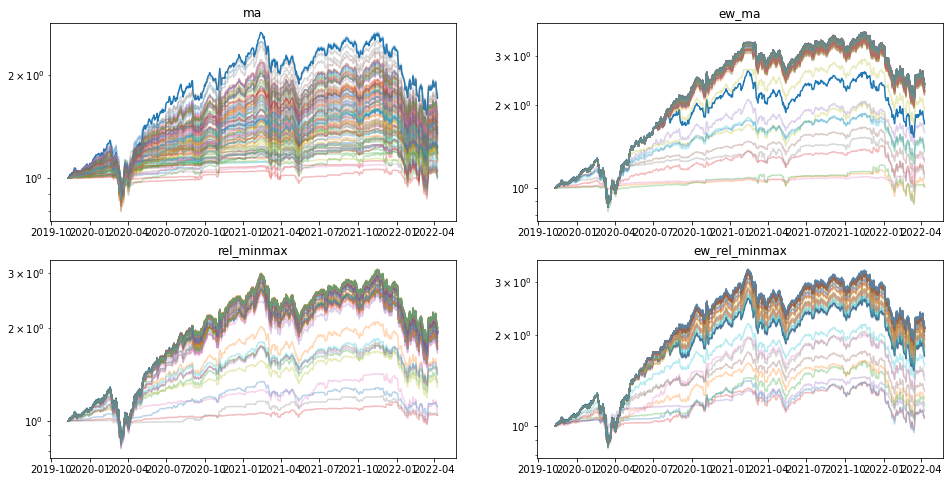

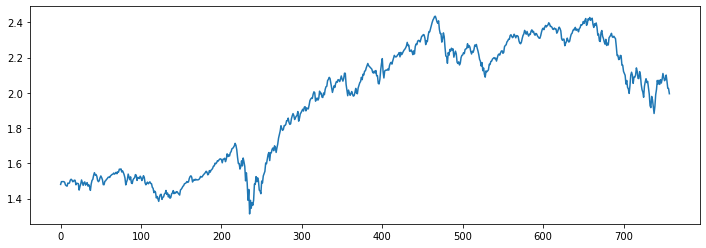

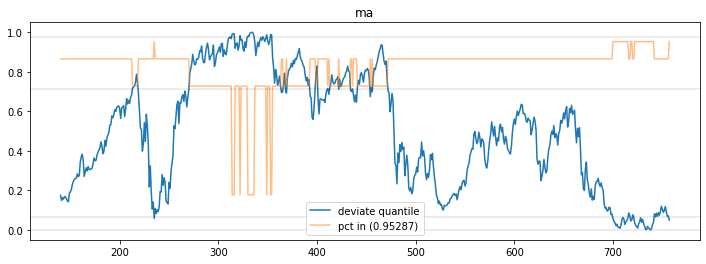

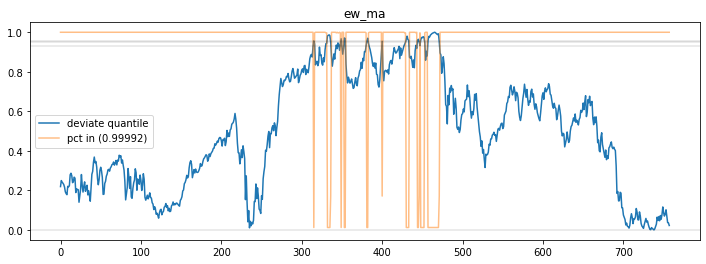

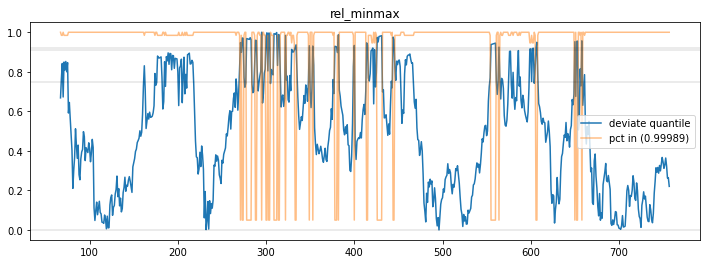

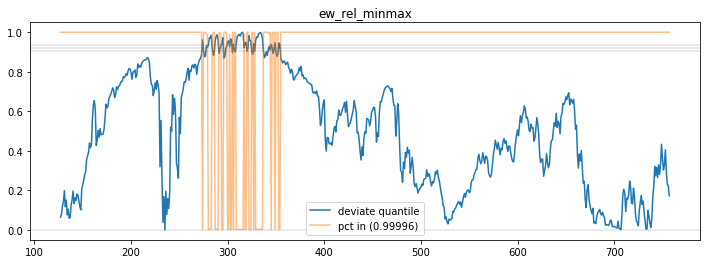

Saving mine2 params...


In [39]:
#N_RAND = 10
#N_ADJ = 90

N_RAND = 5
N_ADJ = 45

print('SD:', SD)
do_nothing_returns = {}
for stock in batch + ['mine1', 'mine2']: # 
    print('\n\n')
    print('-' * 70)
    print(' ' * 32, stock)
    print('-' * 70)
    try:
        best_params, best_returns = read_best_params(stock)
        stock_data = get_stock_data(stock, data)
        stock_data.fillna(method='ffill', inplace=True)
        stock_data.fillna(method='bfill', inplace=True)
        qp = QPercent(
            stock_data, 
            N_CUTS, 
            best_param_set=best_params, 
            best_returns=best_returns, 
            sd=SD)
        qp.run_sims(N_RAND, N_ADJ)
        ###
        for method in ['ma', 'ew_ma', 'rel_minmax', 'ew_rel_minmax']:
            qp.plot_best(method, stock=method == 'ma')
        ###
        best = get_best_param_set(qp)
        save_best_param_set(best, stock)
        do_nothing_returns[stock] = qp.do_nothing_returns
    except BaseException as e:
        print(f'Error encountered\n{e}')

In [58]:
def get_summary(stocks):
    best_returns = {}
    for stock in stocks:
        try:
            with open(f'{DATA}/{stock}_best_{N_YEARS}_years.json', 'r') as f:
                best = json.load(f)
            best_method = None
            best_return = 0
            best_pct = None
            for key in best:
                ret = best[key]['best_return']
                if ret > best_return:
                    best_return = ret
                    best_method = key
                    best_pct = best[key]['pct']
            print(f'\n{stock}:\n  Best Return: {best_return} '
                  f'({best_method})\n  {best_pct:.8f} in')
            data = best[best_method]
            print('time param:', data['time_param'])
            print('qs:')
            for rng, pct in data['q_params'].items():
                lower, upper = [float(x) for x in rng[1:-1].split(', ')]
                print(f'({lower:.4f} - {upper:.4f}): {pct:.4f}')
            best_returns[stock] = {'best_return': best_return, 'pct_in': best_pct}
        except FileNotFoundError:
            print('No data for', stock)
            continue
        except:
            print('Bad Data for', stock)
            continue
    return best_returns

In [59]:
ALL = SYMBOLS + INDICES
#get_summary(ALL)
best_returns = get_summary(batch + ['mine1', 'mine2'])
best_returns


^GSPC:
  Best Return: 1.6415377464470302 (ma)
  0.99994621 in
time param: 110
qs:
(0.0000 - 0.6387): 0.9999
(0.6387 - 0.7784): 0.9991
(0.7784 - 0.8315): 0.9716
(0.8315 - 1.0000): 0.0001

^IXIC:
  Best Return: 1.8680946919256474 (ew_rel_minmax)
  0.99439527 in
time param: 21
qs:
(0.0000 - 0.5217): 0.9999
(0.5217 - 0.6533): 0.9944
(0.6533 - 0.6544): 0.8853
(0.6544 - 1.0000): 0.0353

^NYA:
  Best Return: 1.46758232978217 (ew_rel_minmax)
  0.99801048 in
time param: 75
qs:
(0.0000 - 0.8676): 0.9980
(0.8676 - 0.9157): 0.9703
(0.9157 - 0.9173): 0.0601
(0.9173 - 1.0000): 0.0019

^W5000:
  Best Return: 1.624565833479494 (ew_rel_minmax)
  0.89844681 in
time param: 22
qs:
(0.0000 - 0.1740): 0.9264
(0.1740 - 0.5745): 0.9254
(0.5745 - 0.6807): 0.8984
(0.6807 - 1.0000): 0.0671

mine1:
  Best Return: 2.5976148282034814 (ma)
  0.99998863 in
time param: 114
qs:
(0.0000 - 0.4712): 1.0000
(0.4712 - 0.9754): 0.9991
(0.9754 - 0.9830): 0.9130
(0.9830 - 1.0000): 0.0019

mine2:
  Best Return: 2.3798448046336

{'^GSPC': {'best_return': 1.6415377464470302, 'pct_in': 0.9999462091674697},
 '^IXIC': {'best_return': 1.8680946919256474, 'pct_in': 0.9943952675767588},
 '^NYA': {'best_return': 1.46758232978217, 'pct_in': 0.9980104768394729},
 '^W5000': {'best_return': 1.624565833479494, 'pct_in': 0.8984468108468521},
 'mine1': {'best_return': 2.5976148282034814, 'pct_in': 0.9999886276271704},
 'mine2': {'best_return': 2.379844804633651, 'pct_in': 0.9999161796157252}}

In [60]:
do_nothing_returns

{'^GSPC': 1.4506211065439887,
 '^IXIC': 1.6164629786763716,
 '^NYA': 1.2469097584459574,
 '^W5000': 1.4263907010263852,
 'mine1': 2.392128247686147,
 'mine2': 1.7073697364393514}

In [61]:
for stock in batch + ['mine1', 'mine2']:
    num = best_returns[stock]['best_return']
    den = do_nothing_returns[stock]
    weight = num / den
    if weight <= 1:
        weight = 0
    if stock.startswith('mine'):
        weight /= 2
    best_returns[stock]['weight'] = weight
best_returns

{'^GSPC': {'best_return': 1.6415377464470302,
  'pct_in': 0.9999462091674697,
  'weight': 1.1316102730353126},
 '^IXIC': {'best_return': 1.8680946919256474,
  'pct_in': 0.9943952675767588,
  'weight': 1.1556680954458496},
 '^NYA': {'best_return': 1.46758232978217,
  'pct_in': 0.9980104768394729,
  'weight': 1.176975574889429},
 '^W5000': {'best_return': 1.624565833479494,
  'pct_in': 0.8984468108468521,
  'weight': 1.1389346777923526},
 'mine1': {'best_return': 2.5976148282034814,
  'pct_in': 0.9999886276271704,
  'weight': 0.5429505777368118},
 'mine2': {'best_return': 2.379844804633651,
  'pct_in': 0.9999161796157252,
  'weight': 0.6969330525902135}}

In [62]:
with open(f'{DATA}/qp_{N_YEARS}_weights.json', 'w') as f:
    json.dump(best_returns, f)

In [63]:
!say qp is dunzo